# Transfer predictions from NAGuideR

In [1]:
from pathlib import Path
import logging
import pandas as pd
import matplotlib.pyplot as plt

import vaep
import vaep.models
from vaep.io import datasplits
import vaep.pandas

vaep.plotting.make_large_descriptors(5)

logger = vaep.logging.setup_logger(logging.getLogger('vaep'))

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (csv)
identifer_str: str = '_all_'  # identifier for prediction files to be filtered
dumps: list = None  # list of dumps to be used

In [4]:
# Parameters
dumps = "runs/example/preds/pred_all_ROWMEDIAN.csv,runs/example/preds/pred_all_KNN_IMPUTE.csv,runs/example/preds/pred_all_SEQKNN.csv,runs/example/preds/pred_all_RF.csv,runs/example/preds/pred_all_IMPSEQ.csv,runs/example/preds/pred_all_QRILC.csv,runs/example/preds/pred_all_SVDMETHOD.csv,runs/example/preds/pred_all_MICE-NORM.csv,runs/example/preds/pred_all_MLE.csv,runs/example/preds/pred_all_IRM.csv,runs/example/preds/pred_all_TRKNN.csv,runs/example/preds/pred_all_MSIMPUTE_MNAR.csv,runs/example/preds/pred_all_GSIMP.csv"
folder_experiment = "runs/example"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.args_from_dict(args)
args

{'data': Path('runs/example/data'),
 'dumps': 'runs/example/preds/pred_all_ROWMEDIAN.csv,runs/example/preds/pred_all_KNN_IMPUTE.csv,runs/example/preds/pred_all_SEQKNN.csv,runs/example/preds/pred_all_RF.csv,runs/example/preds/pred_all_IMPSEQ.csv,runs/example/preds/pred_all_QRILC.csv,runs/example/preds/pred_all_SVDMETHOD.csv,runs/example/preds/pred_all_MICE-NORM.csv,runs/example/preds/pred_all_MLE.csv,runs/example/preds/pred_all_IRM.csv,runs/example/preds/pred_all_TRKNN.csv,runs/example/preds/pred_all_MSIMPUTE_MNAR.csv,runs/example/preds/pred_all_GSIMP.csv',
 'file_format': 'csv',
 'folder_data': '',
 'folder_experiment': Path('runs/example'),
 'identifer_str': '_all_',
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds')}

In [6]:
files_out = {}

load data splits

In [7]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/example/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/example/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/example/data/test_y.csv


Validation and test data split of simulated missing values

In [8]:
val_pred_fake_na = data.val_y.to_frame(name='observed')
val_pred_fake_na

,,observed
Sample ID,Gene Names,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250
...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470


In [9]:
test_pred_fake_na = data.test_y.to_frame(name='observed')
test_pred_fake_na.describe()

,observed
count,859.000
mean,28.270
std,2.543
min,22.254
25%,26.477
50%,28.068
75%,30.064
max,35.919


In [10]:
# Find and load prediction files, filter for validation and test data

In [11]:
if args.dumps is not None:
    entire_pred = [Path(s) for s in args.dumps.split(',')]
else:
    entire_pred = list(file for file in args.out_preds.iterdir()
                       if '_all_' in str(file))
entire_pred

[Path('runs/example/preds/pred_all_ROWMEDIAN.csv'),
 Path('runs/example/preds/pred_all_KNN_IMPUTE.csv'),
 Path('runs/example/preds/pred_all_SEQKNN.csv'),
 Path('runs/example/preds/pred_all_RF.csv'),
 Path('runs/example/preds/pred_all_IMPSEQ.csv'),
 Path('runs/example/preds/pred_all_QRILC.csv'),
 Path('runs/example/preds/pred_all_SVDMETHOD.csv'),
 Path('runs/example/preds/pred_all_MICE-NORM.csv'),
 Path('runs/example/preds/pred_all_MLE.csv'),
 Path('runs/example/preds/pred_all_IRM.csv'),
 Path('runs/example/preds/pred_all_TRKNN.csv'),
 Path('runs/example/preds/pred_all_MSIMPUTE_MNAR.csv'),
 Path('runs/example/preds/pred_all_GSIMP.csv')]

In [12]:
mask = data.train_X.unstack().isna().stack()
idx_real_na = mask.index[mask]
idx_real_na = (idx_real_na
               .drop(val_pred_fake_na.index)
               .drop(test_pred_fake_na.index))

for fpath in entire_pred:
    logger.info(f"Load {fpath = }")
    col_name = fpath.stem.split('_all_')[-1]
    pred = pd.read_csv(fpath, index_col=[1, 0])
    val_pred_fake_na[col_name] = pred
    fname = args.out_preds / f'pred_val_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    val_pred_fake_na[['observed', col_name]].to_csv(fname)
    logger.info(f"Save {fname = }")

    test_pred_fake_na[col_name] = pred
    fname = args.out_preds / f'pred_test_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    test_pred_fake_na[['observed', col_name]].to_csv(fname)
    logger.info(f"Save {fname = }")
    # hacky, but works:
    pred_real_na = (pd.Series(0, index=idx_real_na, name='placeholder')
                    .to_frame()
                    .join(pred, how='left')
                    .drop('placeholder', axis=1))
    # pred_real_na.name = 'intensity'
    fname = args.out_preds / f'pred_real_na_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    pred_real_na.to_csv(fname)
    logger.info(f"Save {fname = }")

# del pred

vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_ROWMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_ROWMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_ROWMEDIAN.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_ROWMEDIAN.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_KNN_IMPUTE.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_KNN_IMPUTE.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_KNN_IMPUTE.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_KNN_IMPUTE.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_SEQKNN.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_SEQKNN.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_SEQKNN.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_SEQKNN.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_RF.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_RF.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_RF.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_RF.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_IMPSEQ.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_IMPSEQ.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_IMPSEQ.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_IMPSEQ.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_QRILC.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_QRILC.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_QRILC.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_QRILC.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_SVDMETHOD.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_SVDMETHOD.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_SVDMETHOD.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_SVDMETHOD.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_MICE-NORM.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_MICE-NORM.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_MICE-NORM.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_MICE-NORM.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_MLE.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_MLE.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_MLE.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_MLE.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_IRM.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_IRM.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_IRM.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_IRM.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_TRKNN.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_TRKNN.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_TRKNN.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_TRKNN.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_MSIMPUTE_MNAR.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_MSIMPUTE_MNAR.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_MSIMPUTE_MNAR.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_MSIMPUTE_MNAR.csv')


vaep - INFO     Load fpath = Path('runs/example/preds/pred_all_GSIMP.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_val_GSIMP.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_test_GSIMP.csv')


vaep - INFO     Save fname = Path('runs/example/preds/pred_real_na_GSIMP.csv')


In [13]:
val_pred_fake_na

,,observed,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP
Sample ID,Gene Names,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946,30.547,30.783,30.551,30.665,29.521,26.902,28.035,30.902,"2,355.271",30.758,30.756,27.635,27.398
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248,26.880,26.674,26.599,26.520,26.302,24.980,27.960,26.823,26.870,26.794,26.961,24.500,23.830
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310,26.528,28.596,28.428,28.585,29.055,24.400,29.658,28.842,"2,348.865",28.911,28.814,25.745,22.319
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352,27.521,24.573,25.095,26.551,23.806,24.058,27.192,25.472,27.860,25.891,25.077,23.474,25.276
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250,26.839,28.883,28.931,28.970,28.563,24.492,29.782,28.702,"2,288.717",28.369,29.564,26.330,22.695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294,25.077,24.958,25.168,24.502,23.614,22.225,28.481,24.419,"2,418.402",23.864,24.058,22.365,22.216
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471,27.816,28.949,28.965,28.703,28.680,25.409,28.633,29.740,"2,523.064",29.102,29.097,25.545,24.690
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470,28.381,28.976,29.058,29.248,28.880,25.916,28.893,29.235,-719.987,28.976,29.213,26.188,24.650


Metrics for simulated missing values (NA)

In [14]:
# papermill_description=metrics
d_metrics = vaep.models.Metrics()

In [15]:
added_metrics = d_metrics.add_metrics(val_pred_fake_na.dropna(how='all', axis=1), 'valid_fake_na')
pd.DataFrame(added_metrics)

Selected as truth to compare to: observed


,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP
MSE,1.766,0.695,0.778,0.678,1.910,9.739,5.059,0.774,"4,519,870.934",0.881,0.626,8.134,11.423
MAE,1.028,0.554,0.580,0.536,0.914,2.706,1.763,0.593,"1,893.032",0.648,0.511,2.671,2.994
N,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000
prop,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Test Datasplit

In [16]:
added_metrics = d_metrics.add_metrics(test_pred_fake_na.dropna(how='all', axis=1), 'test_fake_na')
pd.DataFrame(added_metrics)

Selected as truth to compare to: observed


,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP
MSE,1.760,0.534,0.559,0.528,1.829,9.749,5.293,0.586,"4,482,158.000",0.688,0.507,7.900,11.476
MAE,1.040,0.506,0.524,0.508,0.850,2.726,1.829,0.543,"1,890.152",0.598,0.474,2.636,2.986
N,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000
prop,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [17]:
metrics_df = vaep.models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset                     valid_fake_na  test_fake_na
model         metric_name                             
ROWMEDIAN     MSE                  1.766         1.760
              MAE                  1.028         1.040
              N                  859.000       859.000
              prop                 1.000         1.000
KNN_IMPUTE    MSE                  0.695         0.534
              MAE                  0.554         0.506
              N                  859.000       859.000
              prop                 1.000         1.000
SEQKNN        MSE                  0.778         0.559
              MAE                  0.580         0.524
              N                  859.000       859.000
              prop                 1.000         1.000
RF            MSE                  0.678         0.528
              MAE                  0.536         0.508
              N                  859.000       859.000
              prop                 1.000         1.000
IMPSEQ        MSE                  1.910         1.829
              MAE                  0.914         0.850
              N                  859.000       859.000
              prop                 1.000         1.000
QRILC         MSE                  9.739         9.749
              MAE                  2.706         2.726
              N                  859.000       859.000
              prop                 1.000         1.000
SVDMETHOD     MSE                  5.059         5.293
              MAE                  1.763         1.829
              N                  859.000       859.000
              prop                 1.000         1.000
MICE-NORM     MSE                  0.774         0.586
              MAE                  0.593         0.543
              N                  859.000       859.000
              prop                 1.000         1.000
MLE           MSE          4,519,870.934 4,482,158.000
              MAE              1,893.032     1,890.152
              N                  859.000       859.000
              prop                 1.000         1.000
IRM           MSE                  0.881         0.688
              MAE                  0.648         0.598
              N                  859.000       859.000
              prop                 1.000         1.000
TRKNN         MSE                  0.626         0.507
              MAE                  0.511         0.474
              N                  859.000       859.000
              prop                 1.000         1.000
MSIMPUTE_MNAR MSE                  8.134         7.900
              MAE                  2.671         2.636
              N                  859.000       859.000
              prop                 1.000         1.000
GSIMP         MSE                 11.423        11.476
              MAE                  2.994         2.986
              N                  859.000       859.000
              prop                 1.000         1.000

In [18]:
order_methods = metrics_df.loc[pd.IndexSlice[:,
                                             'MAE'], 'valid_fake_na'].sort_values()
order_methods

model          metric_name
TRKNN          MAE               0.511
RF             MAE               0.536
KNN_IMPUTE     MAE               0.554
SEQKNN         MAE               0.580
MICE-NORM      MAE               0.593
IRM            MAE               0.648
IMPSEQ         MAE               0.914
ROWMEDIAN      MAE               1.028
SVDMETHOD      MAE               1.763
MSIMPUTE_MNAR  MAE               2.671
QRILC          MAE               2.706
GSIMP          MAE               2.994
MLE            MAE           1,893.032
Name: valid_fake_na, dtype: float64

In [19]:
top_5 = ['observed', *order_methods.droplevel(-1).index[:6]]
top_5

['observed', 'TRKNN', 'RF', 'KNN_IMPUTE', 'SEQKNN', 'MICE-NORM', 'IRM']

vaep.plotting - INFO     Saved Figures to runs/example/figures/NAGuideR_errors_per_bin_val.png


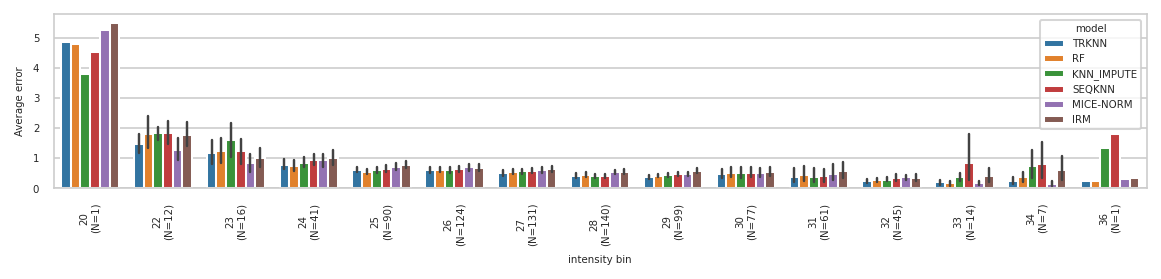

In [20]:
fig, ax = plt.subplots(figsize=(8, 2))
ax, errors_bind = vaep.plotting.errors.plot_errors_binned(
    val_pred_fake_na[top_5],
    ax=ax,
)
fname = args.out_figures / 'NAGuideR_errors_per_bin_val.png'
files_out[fname.name] = fname.as_posix()
vaep.savefig(ax.get_figure(), fname)

In [21]:
files_out

{'pred_val_ROWMEDIAN.csv': 'runs/example/preds/pred_val_ROWMEDIAN.csv',
 'pred_test_ROWMEDIAN.csv': 'runs/example/preds/pred_test_ROWMEDIAN.csv',
 'pred_real_na_ROWMEDIAN.csv': 'runs/example/preds/pred_real_na_ROWMEDIAN.csv',
 'pred_val_KNN_IMPUTE.csv': 'runs/example/preds/pred_val_KNN_IMPUTE.csv',
 'pred_test_KNN_IMPUTE.csv': 'runs/example/preds/pred_test_KNN_IMPUTE.csv',
 'pred_real_na_KNN_IMPUTE.csv': 'runs/example/preds/pred_real_na_KNN_IMPUTE.csv',
 'pred_val_SEQKNN.csv': 'runs/example/preds/pred_val_SEQKNN.csv',
 'pred_test_SEQKNN.csv': 'runs/example/preds/pred_test_SEQKNN.csv',
 'pred_real_na_SEQKNN.csv': 'runs/example/preds/pred_real_na_SEQKNN.csv',
 'pred_val_RF.csv': 'runs/example/preds/pred_val_RF.csv',
 'pred_test_RF.csv': 'runs/example/preds/pred_test_RF.csv',
 'pred_real_na_RF.csv': 'runs/example/preds/pred_real_na_RF.csv',
 'pred_val_IMPSEQ.csv': 'runs/example/preds/pred_val_IMPSEQ.csv',
 'pred_test_IMPSEQ.csv': 'runs/example/preds/pred_test_IMPSEQ.csv',
 'pred_real_na_I